## BackPropagation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import struct
import sklearn.preprocessing
import random as r
import scipy.misc
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def soft_softmax(x):
    x = np.array([x[i] - np.max(x[i]) for i in xrange(x.shape[0])])
    x = np.array([np.exp(x[i]) / np.sum(np.exp(x[i])) for i in xrange(x.shape[0])])
    return x

def activate(activate, x):
    if activate == 'sigmoid':
        return (1 / (1 + np.exp(-x)))
    elif activate == 'tanh':
        return np.tanh(x)
    elif activate == 'softmax':
        return soft_softmax(x)
    elif activate == 'ReLU':
        for i in xrange(x.shape[0]):
            for j in xrange(x.shape[1]):
                if (x[i][j] < 0):
                    x[i][j] = 0
        return x 
    
def deriv_activ(activate, x):
    if activate == 'sigmoid':
        return x * (1 - x)
    elif activate == 'tanh':
        return (1.0 - x**2)  
    elif activate == 'softmax':
        return x * (1 - x)
    elif activate == 'ReLU':
        for i in xrange(x.shape[0]):
            for j in xrange(x.shape[1]):
                if (x[i][j] < 0):
                    x[i][j] = 0
                else:
                    x[i][j] = 1
        return x 

In [3]:
class Layer:
    def __init__(self, num_nodes, prev_num_nodes = -1, bias = True, activate = "sigmoid"):
        self.num_nodes = num_nodes
        self.prev_num_nodes = prev_num_nodes
        self.need_bias = bias;
        print self.need_bias
        if (self.need_bias):
            self.bias = 2 * np.random.random((1, num_nodes)) - 1
        self.weights_matrix = None
        self.activate = activate

    def forward_pass(self, X):
        if (self.weights_matrix is None) and (self.prev_num_nodes != 1):
            self.weights_matrix = 2*np.random.random((self.prev_num_nodes, self.num_nodes)) - 1
            #self.weights_matrix = np.array([[0.1], [0.1]])
        
        #print np.dot(X, self.weights_matrix)
        #print "WEIGHTS: " + str(self.weights_matrix)
        if (self.need_bias):
            self.Y = activate(self.activate, np.dot(X, self.weights_matrix) + self.bias)
        else:
            self.Y = activate(self.activate, np.dot(X, self.weights_matrix))
        
        return self.Y
    
    def backward_pass(self, WeightedGradientNextLayer, learning_ratio, Y_prev): 
        #calculate gradient and update weights
        Delta = WeightedGradientNextLayer * deriv_activ(self.activate, self.Y)
        Gradient = Y_prev.T.dot(Delta)
        #print "Gradient 0: " + str(Gradient)
        self.weights_matrix -= learning_ratio * Gradient
        
        if (self.need_bias):
            #print "bias", self.bias
            #print "delta", Delta.sum()
            #print "Delta shape", Delta.shape
            self.bias -= learning_ratio * Delta.mean(0)
        
        return (Delta.dot(self.weights_matrix.T))
    
class OutputLayer(Layer):
    def backward_begin (self, loss_function, OUT, learning_ratio, Y_prev):
        
        if loss_function == "MSE":
            Delta = -1 *(OUT - self.Y) * deriv_activ(self.activate, self.Y)
            Gradient = Y_prev.T.dot(Delta)
            Error = (((OUT - self.Y)**2).mean(axis = 1)).mean()
            #print "Gradient" + str(Gradient)
            self.weights_matrix -= learning_ratio * Gradient
            if (self.need_bias):
                #print "bias", self.bias
                #print "delta", Delta.sum()
                self.bias -= learning_ratio * Delta.mean(0)
            
            
        elif loss_function == "NLL":
            
            #x = np.copy(self.Y)
            #for sample in xrange(x.shape[0]):
            #    x[sample] = x[sample] - scipy.misc.logsumexp(x[sample])
            
            Error = -1 * (OUT * np.log(self.Y)).sum()
            
            #print self.Y
            Delta = (self.Y - OUT)
            Gradient = Y_prev.T.dot(Delta)
            #print "Gradient: " + str(Gradient[0])
            self.weights_matrix -= learning_ratio * Gradient
            if (self.need_bias):
                #print self.bias
                #print Delta.sum()
                self.bias -= learning_ratio * Delta.mean(0)
        
        return Delta.dot(self.weights_matrix.T), Error
    
    
class InputLayer(Layer):
    def forward_begin (self, X):
        self.Y = X
        
        return self.Y
        
        

In [4]:
a = np.array([[1, 0, 0], [0, 1, 1]])
b = np.array([[0.5, 0.3, 0.8], [3, 4, 5]])

print a - b

[[ 0.5 -0.3 -0.8]
 [-3.  -3.  -4. ]]


In [5]:
class Neural_Network:
    def __init__(self, layers):
        self.layers = layers
        
    def fit(self, X, OUT, batch_size, iteration, learning_ratio, loss_function):

        for iterat in xrange(iteration):
            
            batch_sample = r.sample(xrange(X.shape[0]), batch_size)                
            #batch_sample = xrange(batch_size)
            
            self.layers[0].forward_begin(X[batch_sample])
            
            for i in xrange(1, len(self.layers)):
                self.layers[i].forward_pass(self.layers[i - 1].Y)
    
            WeightedGradientNextLayer_tmp, Error = self.layers[len(self.layers) - 1].backward_begin(loss_function,\
                                                        OUT[batch_sample], learning_ratio, \
                                                        self.layers[len(self.layers) - 2].Y)
        
            for i in xrange(len(self.layers) - 2, 0, -1):
                WeightedGradientNextLayer_tmp = self.layers[i].backward_pass(WeightedGradientNextLayer_tmp, \
                                                                       learning_ratio, self.layers[i - 1].Y)
            
            right_cnt = 0
            if iterat % 300 == 0:
                print "________________________________________________"
                print "Iteration: " + str(iterat)
                print 'Error: '  + str(Error)
                #print "Y_i: " + str(np.argmax(self.layers[len(self.layers) - 1].Y[0]))
                #print "OUT: " + str(np.argmax(OUT[batch_sample[0]]))
                for i in xrange(batch_size):
                    if np.argmax(self.layers[len(self.layers) - 1].Y[i]) == np.argmax(OUT[batch_sample[i]]):
                        right_cnt += 1
                
                print "True identified: " + str(right_cnt) + "|" + str(batch_size)
            
                
    
    def predict(self, X):
        self.layers[0].forward_begin(X)
        for i in xrange(1, len(self.layers)):
            self.layers[i].forward_pass(self.layers[i - 1].Y)
        
        if self.layers[len(self.layers) - 1].activate == 'softmax':
            self.layers[len(self.layers) - 1].Y = soft_softmax(self.layers[len(self.layers) - 1].Y)
        return self.layers[len(self.layers) - 1].Y
                
                

In [6]:
print r.sample(xrange(100), 5)

[57, 81, 98, 9, 15]


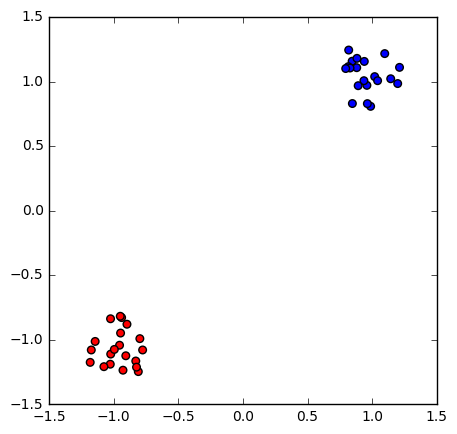

In [25]:
simple_train =np.array([[-1.0, -1.0]] * 20 + [[1, 1.0]] * 20)
simple_check = np.array([[1.0, 0.0]] * 20 + [[0.0, 1.0]] * 20)

for i in xrange(len(simple_train)):
    (simple_train[i])[0] += np.random.sample() / 2 - 0.25
    (simple_train[i])[1] += np.random.sample() / 2 - 0.25
    
plt.figure(figsize = (5, 5))
plt.scatter(simple_train[:, 0], simple_train[:, 1],s = 30,\
            c = ['r' if simple_check[i][0] == 1.0 else 'b' for i in xrange(len(simple_check))])
plt.show()  

In [26]:
Layer1 = InputLayer(num_nodes = 2, bias = True)
Layer2 = OutputLayer(num_nodes = 2, prev_num_nodes = 2,bias = True,activate = 'softmax')

simple_model = Neural_Network([Layer1, Layer2])
simple_model.fit(simple_train, simple_check, 20, 400, learning_ratio = 0.1, loss_function = "NLL")
print Layer2.weights_matrix
print Layer2.bias

True
True
________________________________________________
Iteration: 0
Error: 13.5021324175
True identified: 10|20
________________________________________________
Iteration: 300
Error: 0.00741896689703
True identified: 20|20
[[-2.25235604  1.37164913]
 [-1.89256492  2.75697104]]
[[-0.18265891 -0.67271669]]


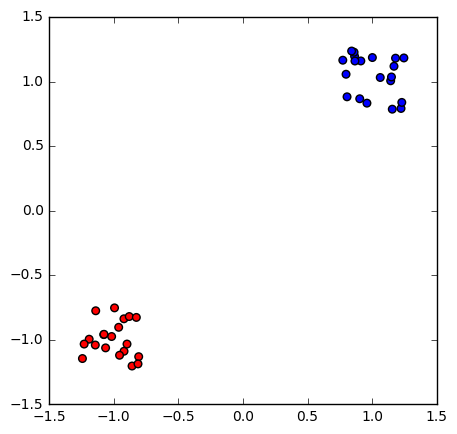

In [28]:
#на этих тестировать 
simple_test =np.array([[-1.0, -1]] * 20 + [[1, 1.0]] * 20)

for i in xrange(len(simple_test)):
    (simple_test[i])[0] += np.random.sample() / 2 - 0.25
    (simple_test[i])[1] += np.random.sample() / 2 - 0.25
    
simple_predict = simple_model.predict(simple_test)
#print simple_predict
    
plt.figure(figsize = (5, 5))
plt.scatter(simple_test[:, 0], simple_test[:, 1],s = 30,\
            c = ['r' if simple_predict[i][0] > 0.5 else 'b' for i in xrange(len(simple_check))])
plt.show() 

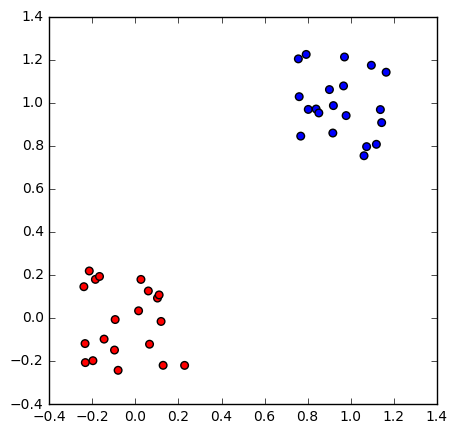

True
True
________________________________________________
Iteration: 0
Error: 0.282457149134
True identified: 20|20
________________________________________________
Iteration: 300
Error: 0.0293850099446
True identified: 20|20
[[ 2.8751021 ]
 [ 1.81913215]]
[[-1.36627566]]
[[ 0.23853004]
 [ 0.3625532 ]
 [ 0.2621269 ]
 [ 0.37049347]
 [ 0.23330373]
 [ 0.25991106]
 [ 0.10630429]
 [ 0.3397883 ]
 [ 0.12458696]
 [ 0.09234842]
 [ 0.30575672]
 [ 0.25071828]
 [ 0.18152012]
 [ 0.13218504]
 [ 0.1487261 ]
 [ 0.1223818 ]
 [ 0.22291501]
 [ 0.39938688]
 [ 0.15633098]
 [ 0.14264692]
 [ 0.97567224]
 [ 0.97813757]
 [ 0.94840952]
 [ 0.98047358]
 [ 0.98505322]
 [ 0.95710016]
 [ 0.96823625]
 [ 0.96408756]
 [ 0.9675088 ]
 [ 0.98419475]
 [ 0.94670539]
 [ 0.92064936]
 [ 0.96224693]
 [ 0.9797638 ]
 [ 0.96288949]
 [ 0.92302454]
 [ 0.97588148]
 [ 0.97339708]
 [ 0.945659  ]
 [ 0.98338319]]


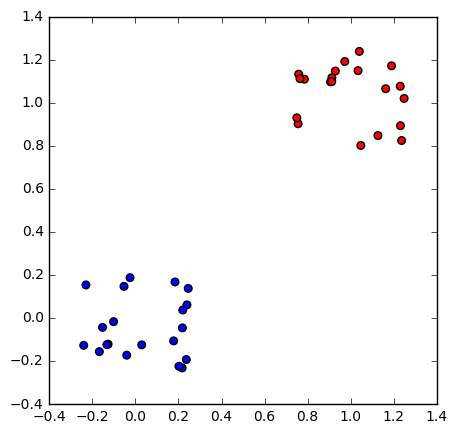

In [33]:
simple_train =np.array([[0, 0]] * 20 + [[1, 1.0]] * 20)
simple_check = np.array([[0.0]] * 20 + [[1.0]] * 20)

for i in xrange(len(simple_train)):
    (simple_train[i])[0] += np.random.sample() / 2 - 0.25
    (simple_train[i])[1] += np.random.sample() / 2 - 0.25
    
#на этих данных буду обучать
plt.figure(figsize = (5, 5))
plt.scatter(simple_train[:, 0], simple_train[:, 1],s = 30, c = ['r' if simple_check[i][0] == 0 else 'b' for i in xrange(len(simple_check))])
plt.show() 

Layer1 = InputLayer(num_nodes = 2)
Layer2 = OutputLayer(num_nodes = 1, prev_num_nodes = 2,bias = True,activate = 'sigmoid')

simple_model = Neural_Network([Layer1, Layer2])
simple_model.fit(simple_train, simple_check, 20, 400, learning_ratio = 0.1, loss_function = "MSE")
print Layer2.weights_matrix
print Layer2.bias

#на этих тестировать 
simple_test =np.array([[0.0, 0]] * 20 + [[1, 1.0]] * 20)

for i in xrange(len(simple_test)):
    (simple_test[i])[0] += np.random.sample() / 2 - 0.25
    (simple_test[i])[1] += np.random.sample() / 2 - 0.25
    
simple_predict = simple_model.predict(simple_test)
print simple_predict
    
plt.figure(figsize = (5, 5))
plt.scatter(simple_test[:, 0], simple_test[:, 1],s = 30,\
            c = ['r' if simple_predict[i][0] > 0.5 else 'b' for i in xrange(len(simple_check))])
plt.show() 

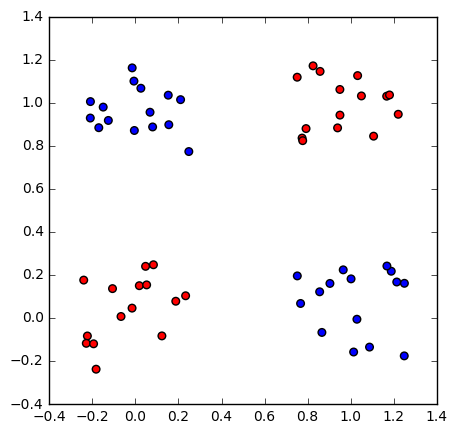

In [157]:
XOR_train = np.array([[0.0, 0]] * 15 + [[0.0, 1]] * 15 + [[1, 0.0]] * 15 + [[1, 1.0]] * 15)
XOR_check = np.array([[1.0, 0.0]] *15 + [[0.0, 1.0]] *15 + [[0.0, 1.0]] *15 + [[1.0, 0.0]] *15)

#XOR_train = np.array([[0.0, 0]] + [[0.0, 1]] + [[1, 0.0]] + [[1, 1.0]])
#XOR_check = np.array([[1.0, 0.0]] + [[0.0, 1.0]] + [[0.0, 1.0]]  + [[1.0, 0.0]])

for i in xrange(len(XOR_train)):
    (XOR_train[i])[0] += np.random.sample() / 2 - 0.25
    (XOR_train[i])[1] += np.random.sample() / 2 - 0.25
    
#на этих данных буду обучать
plt.figure(figsize = (5, 5))
plt.scatter(XOR_train[:, 0], XOR_train[:, 1], s = 30, c = ['r' if XOR_check[i][1] == 0 else 'b' for i in xrange(len(XOR_check))])
plt.show()                 

In [158]:
inp = InputLayer(2)
hidden = Layer(3, 2,bias = True, activate = "sigmoid")
outp = OutputLayer(2, 3, bias = True, activate = "softmax")

print [inp, hidden, outp]
XOR_model = Neural_Network(layers = [inp, hidden, outp])
XOR_model.fit(XOR_train, XOR_check, 30, 3000, learning_ratio = 0.01, loss_function = "NLL")

True
True
True
[<__main__.InputLayer instance at 0x7f10d8b420e0>, <__main__.Layer instance at 0x7f10d8b42098>, <__main__.OutputLayer instance at 0x7f10d8b428c0>]
________________________________________________
Iteration: 0
Error: 21.4042728759
True identified: 16|30
________________________________________________
Iteration: 300
Error: 20.3116758306
True identified: 21|30
________________________________________________
Iteration: 600
Error: 17.9549243256
True identified: 20|30
________________________________________________
Iteration: 900
Error: 9.27661557774
True identified: 30|30
________________________________________________
Iteration: 1200
Error: 4.19118113087
True identified: 29|30
________________________________________________
Iteration: 1500
Error: 2.55796824471
True identified: 30|30
________________________________________________
Iteration: 1800
Error: 1.67247860775
True identified: 30|30
________________________________________________
Iteration: 2100
Error: 1.2632440

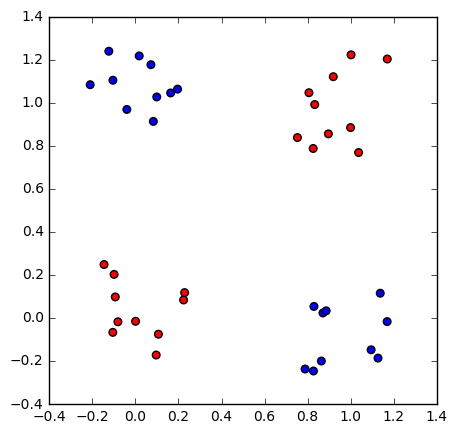

In [159]:
#на этих тестировать 
XOR_test =np.array([[0.0, 0]] * 10 + [[0.0, 1]] * 10 + [[1, 0.0]] * 10 + [[1, 1.0]] * 10)

for i in xrange(len(XOR_test)):
    (XOR_test[i])[0] += np.random.sample() / 2 - 0.25
    (XOR_test[i])[1] += np.random.sample() / 2 - 0.25
    
XOR_predict = XOR_model.predict(XOR_test)

plt.figure(figsize = (5, 5))
plt.scatter(XOR_test[:, 0], XOR_test[:, 1],s = 30, c = ['r' if XOR_predict[i][1] <= 0.5 else 'b' for i in xrange(len(XOR_predict))])
plt.show()  

In [160]:
def read(dataset = "training", path = "/home/dana_zl/Technosphera/Neural_Network/"):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    else:
        raise ValueError, "dataset must be 'testing' or 'training'"
        
    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)
        
    print img.shape
    print lbl, len(lbl)
    
    IMG = np.array([img[i].reshape(784) for i in xrange(len(lbl))])
    LBL = np.zeros((len(lbl), 10))
    for i in xrange(len(lbl)):
        LBL[i][lbl[i]] = 1
    
    return IMG, LBL

def show(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()

In [161]:
TRAIN_IMG, TRAIN_LBL = read(dataset = "training")
TRAIN_IMG_NORM = sklearn.preprocessing.normalize(TRAIN_IMG, norm = 'max')
print TRAIN_LBL.shape

(60000, 28, 28)
[5 0 4 ..., 5 6 8] 60000
(60000, 10)


In [162]:
print str(TRAIN_IMG[20007].reshape(28, 28))
print TRAIN_LBL[20007]

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  15  24 118 138 139 138 138  97  24  22   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  57 219 252 252 252 253 252 252 252 252 245 140  13   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 253 252 252 252 252 253 252 252 252 252 253 252 171  13
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  56 160 160 160  56  46  45  45  45  98 211 252 252 139
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  34 25

In [163]:
inp = InputLayer(784)
hidden = Layer(300, prev_num_nodes = 784, bias = True, activate = "sigmoid")
out = OutputLayer(10, prev_num_nodes = 300, bias = True, activate = 'softmax')

MNIST_model = Neural_Network([inp, hidden, out])
MNIST_model.fit(TRAIN_IMG_NORM, TRAIN_LBL, 60, 4000, learning_ratio = 0.01, loss_function = "NLL")

True
True
True
________________________________________________
Iteration: 0
Error: 556.428053854
True identified: 5|60
________________________________________________
Iteration: 300
Error: 31.2523226987
True identified: 52|60
________________________________________________
Iteration: 600
Error: 15.0941336163
True identified: 54|60
________________________________________________
Iteration: 900
Error: 21.3465251782
True identified: 53|60
________________________________________________
Iteration: 1200
Error: 20.2972826401
True identified: 53|60
________________________________________________
Iteration: 1500
Error: 10.6912358814
True identified: 56|60
________________________________________________
Iteration: 1800
Error: 7.77013751613
True identified: 56|60
________________________________________________
Iteration: 2100
Error: 5.64222829964
True identified: 58|60
________________________________________________
Iteration: 2400
Error: 10.1577269537
True identified: 56|60
___________

In [164]:
TEST_IMG, TEST_LBL = read(dataset = "testing")
TEST_IMG_NORM = sklearn.preprocessing.normalize(TEST_IMG, norm = 'max')

(10000, 28, 28)
[7 2 1 ..., 4 5 6] 10000


In [165]:
right_cnt = 0
predict = MNIST_model.predict(TEST_IMG_NORM)
for i in xrange(predict.shape[0]):
    if np.argmax(predict[i]) == np.argmax(TEST_LBL[i]):
        right_cnt += 1
                
print "True identified: " + str(right_cnt) + "|" + str(predict.shape[0])

True identified: 9504|10000


In [166]:
print predict[0]

[ 0.08533729  0.08533729  0.08533735  0.08534093  0.08533729  0.08533729
  0.08533729  0.23196072  0.08533729  0.08533729]
